# Titanic challenge, my first kaggle challenge

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the Data

In [2]:
df_start = pd.read_csv('train.csv')

In [3]:
df_start

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_start["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Initial visualization

Saving figure attribute_histogram_plots


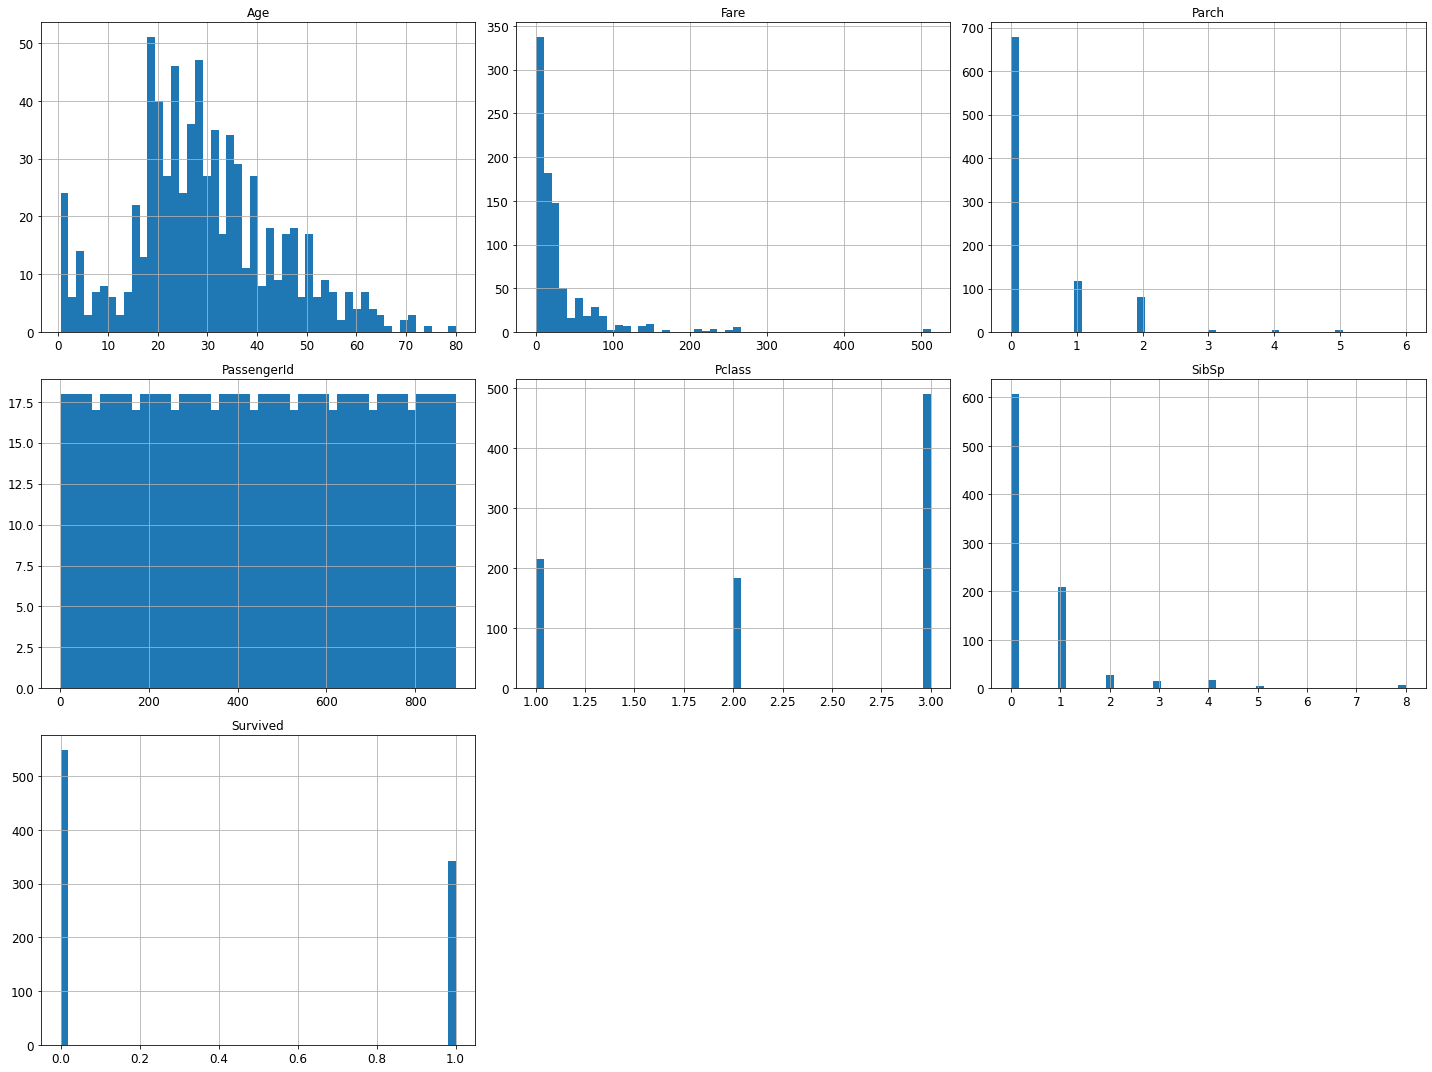

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
df_start.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

### Scatter matrix

Saving figure scatter_matrix_plot


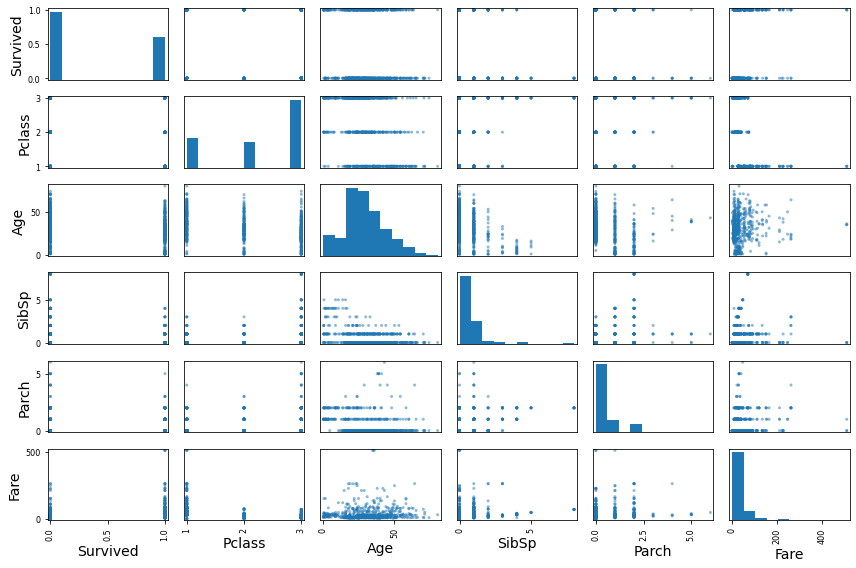

In [7]:
from pandas.plotting import scatter_matrix

attributes = ["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare",]
scatter_matrix(df_start[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [8]:
# import dcor
# # some pre-treatments are needed
# housing_clean.drop("ocean_proximity", axis=1, inplace=True)
# median = housing_clean['total_bedrooms'].median()
# housing_clean['total_bedrooms'].fillna(median, inplace=True) # inplace=True reverts default pandas treatment, which would do copy
# # i want to create a pandas dataframe where i compute for each column of the dataset the distance 
# # correlation with every other column of the dataset
# # need to do two-fold loop of the dataframe columns 
# #housing.info()
# discorr = np.ones((len(housing_clean.columns),len(housing.columns)))
# print(discorr.shape)
# for iX,(labelX,X) in enumerate(housing_clean.items()):
#   for iY,(labelY,Y) in enumerate(housing_clean.items()):
#     discorr[iX,iY] = dcor.distance_correlation(X.to_numpy(),Y.to_numpy())
#     #print(labelX,labelY,disco[iX,iY])

# heatmap = sns.heatmap(discorr, annot=True, vmin=-1, vmax=1)
# heatmap.get_figure()#.savefig("./images/end_to_end_project/correlation_disco.png")
# save_fig("correlation_disco", tight_layout=False)

## Data pre-processing

Important note: in this notebook, we apply transformations by means of a sklearn trasformer.
This provides to a tidy code.
However, the syntax may be significantly simpler if one were to apply the transformations directly using the application of functions (apply) on the dataframe.
In the next project, I invite myself to try this second strategy.

### Tranformer for the "Cabin"

Idea here is to extract the sector of the cabin, to see if there is any correlation with the survival probability.

We also extract the number of the cabin, although we don't expect it to have a significant correlation with the outcome.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin


def cabin_sector_function(x):
  '''
  Assign a sector number, based on cabin attribute, 
  e.g. C85 => sector "C" => assign number 3
  If "Cabin" attribute is empty, assign 0
  '''
  classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
  mapping = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
  assigned_sector = 0
  #found_class = 'Z'
  for c in classes:
    if c in str(x):
      assigned_sector = mapping[c]
  return assigned_sector

def cabin_number_function(x):
  '''
  Extract the number of the cabin, based on the cabin attribute
  e.g. C85 => number 85
  if multiple cabins available, pick up only the first one
  if field is empty, assign 0
  '''
  import re
  ns = re.findall(r'\d+', str(x))
  if len(ns)>0:
    return int(ns[0])
  else:
    return 0
  #ns = [int(s) for s in x.split() if s.isdigit()]

# array = df_start.values[:10,10]
# print(array)
vec_cabin_sector_function = np.vectorize(cabin_sector_function)
vec_cabin_number_function = np.vectorize(cabin_number_function)
# sector_cat = vec_cabin_sector_function(array)
# number_num = vec_cabin_number_function(array)
# print(sector_cat)
# print(number_num)


## column index
#cabin_ix = 10 #bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CabinAttributesAdder (BaseEstimator, TransformerMixin):
  '''
  To be applied to the cabin category directly
  '''
  def __init__(self,addCabinNumber=False):
    self.addCabinNumber = addCabinNumber
  def fit(self, X, y=None):
    return self
  def transform(self,X):
    #sector_cat = sector_function(X[:,cabin_ix])
    sector_num = vec_cabin_sector_function(X)
    cabin_num = vec_cabin_number_function(X)
    if self.addCabinNumber:
      return np.c_[sector_num, cabin_num]
    else:
      return sector_num
    
attr_adder = CabinAttributesAdder(addCabinNumber=True)
extra_attribs = attr_adder.transform(df_start['Cabin'].values)
print(extra_attribs.shape)
extra_attribs[:10,:]

(891, 2)


array([[  0,   0],
       [  3,  85],
       [  0,   0],
       [  3, 123],
       [  0,   0],
       [  0,   0],
       [  5,  46],
       [  0,   0],
       [  0,   0],
       [  0,   0]])

### Transformer for the "Name": get the number of characters

We want to get the number of characters of the name, as a longer name may be correlated with higher social stuatus, and higher probability of survival


In [10]:
def name_count_function(x):
  return len(str(x))
vec_name_count_function = np.vectorize(name_count_function)
#array = df_start['Name'].values

class NameAttributeCounter (BaseEstimator, TransformerMixin):
  '''
  To be applied to the name category
  '''
  def fit(self, X, y=None):
    return self
  def transform(self,X):
    name_num = vec_name_count_function(X)
    return name_num
    
name_counter = NameAttributeCounter()
extra_attribs = name_counter.transform(df_start['Name'].values)
print(extra_attribs.shape)
extra_attribs[:10]

(891,)


array([23, 51, 22, 44, 24, 16, 23, 30, 49, 35])

### Transformer for the "Name": get the title

Another potentially interesting characteristic is the title, for the same reasons as above 
We want to use this one as a categorical variable, and in order to set a meaningful order, we create two categories, one for female titles and the other one for male titles. For females (males), if the title is for males (females), a default value will be set (-9).

**TODO** change the default value from -9 to -1

In [11]:
#df_start['Title'] = df_start['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])
#df_start['Title'].value_counts()

In [12]:
female_title_mapping = {
'the Countess': 6,
'Lady': 5,
'Mme': 4,
'Ms': 3,
'Mlle': 2,
'Mrs': 1,
'Miss': 0,
}
male_title_mapping = {
'Master': 0,
'Mr': 1,
'Dr': 2,
'Sir': 3,
'Don': 4,
'Rev': 5,
'Col': 6,
'Major': 7,
'Capt': 8,
'Jonkheer': 9,
}

def name_female_title_function(x):
  title = str(x).split(', ')[1].split('.')[0]
  female_title = -1
  try: 
    female_title = female_title_mapping[title]
  except:
    pass
  return female_title

def name_male_title_function(x):
  title = str(x).split(', ')[1].split('.')[0]
  male_title = -1
  try: 
    male_title = male_title_mapping[title]
  except:
    pass
  return male_title

vec_name_female_title_function = np.vectorize(name_female_title_function)
vec_name_male_title_function = np.vectorize(name_male_title_function)

class NameAttributeTranformer (BaseEstimator, TransformerMixin):
  '''
  To be applied to the name category
  '''
  def fit(self, X, y=None):
    return self
  def transform(self,X):
    name_female_title = vec_name_female_title_function(X)
    name_male_title = vec_name_male_title_function(X)
    return np.c_[name_female_title, name_male_title]
    
name_transformer = NameAttributeTranformer()
extra_attribs = name_transformer.transform(df_start['Name'].values)
print(extra_attribs.shape)
extra_attribs[:10]

(891, 2)


array([[-1,  1],
       [ 1, -1],
       [ 0, -1],
       [ 1, -1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  0],
       [ 1, -1],
       [ 1, -1]])

### Attribute adder for family-related information

In [13]:
class FamilyAttributesAdder (BaseEstimator, TransformerMixin):
  '''
  To add an attribute given by SibSp + Parch, and hasFamily
  Assumes that X is a pd.DataFrame
  Returns a 2D np array with initial features and computed features concatenated
  '''
  def fit(self, X, y=None):
    return self
  def transform(self,X):
    X["totalFamily"] = X["SibSp"] + X["Parch"]
    X["hasFamily"] = (X["totalFamily"]>0)*1
    return np.c_[X["SibSp"].values, X["Parch"].values, X["totalFamily"].values, X["hasFamily"].values]

family_attrAdder = FamilyAttributesAdder()
extra_attribs = family_attrAdder.transform(df_start[["Parch","SibSp"]]) #
print(extra_attribs.shape)
extra_attribs[:10] 

(891, 4)


/var/folders/n_/3tsts8n517l9sdcmgskvkyqc0000gn/T/ipykernel_90963/2273178813.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["totalFamily"] = X["SibSp"] + X["Parch"]
/var/folders/n_/3tsts8n517l9sdcmgskvkyqc0000gn/T/ipykernel_90963/2273178813.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hasFamily"] = (X["totalFamily"]>0)*1


array([[1, 0, 1, 1],
       [1, 0, 1, 1],
       [0, 0, 0, 0],
       [1, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [3, 1, 4, 1],
       [0, 2, 2, 1],
       [1, 0, 1, 1]])

### Detour: examples of min-max scaling vs standardadization

For two different kind of distribution, I want to visualise the effect of min-max scaling vs standardisation.

The distributions are: age (multimodal), fare (more skewed, with outliers)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

df_bf_scaling = df_start[['Age', 'Fare']]
#df_bf_scaling['Age'].fillna(df_bf_scaling['Age'].median(), inplace=True)
#df_bf_scaling['Fare'].fillna(df_bf_scaling['Fare'].median(), inplace=True)


std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

features_np_aft_std = std_scaler.fit_transform(df_bf_scaling)
features_np_aft_minmax = minmax_scaler.fit_transform(df_bf_scaling)

features_np_aft_std.shape,features_np_aft_minmax.shape

((891, 2), (891, 2))

/Users/mratti/opt/miniconda3/envs/titanic/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mratti/opt/miniconda3/envs/titanic/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


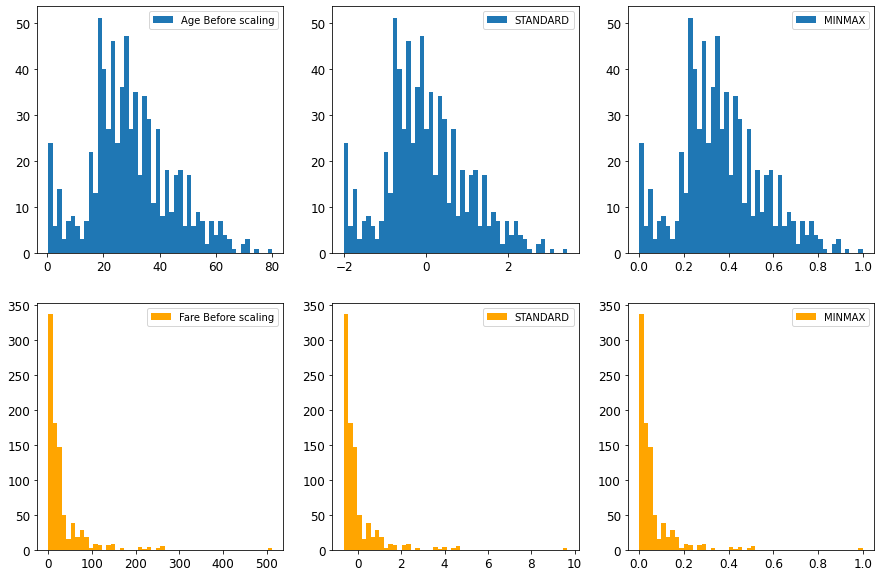

In [15]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax[0,0].hist(df_bf_scaling['Age'], bins=50, label='Age Before scaling')
ax[0,0].legend()
ax[0,1].hist(features_np_aft_std[:,0], bins=50, label='STANDARD')
ax[0,1].legend()
ax[0,2].hist(features_np_aft_minmax[:,0], bins=50, label='MINMAX')
ax[0,2].legend()

ax[1,0].hist(df_bf_scaling['Fare'], bins=50, color='orange', label='Fare Before scaling')
ax[1,0].legend()
ax[1,1].hist(features_np_aft_std[:,1], bins=50, color='orange', label='STANDARD')
ax[1,1].legend()
ax[1,2].hist(features_np_aft_minmax[:,1], bins=50, color='orange', label='MINMAX')
ax[1,2].legend()

plt.show()

Both methods only change the x-axis scale, they do not modify the distribution. 

Generally, one prefers the **standardisation** when one has a **distribution with outliers**: in this way the majority of the events is in the range [0,1], [-1,1] (it depends a bit from the distribution. If in this case one were to use the min-max scaling, one would end up with most events in a very restricted range and the outlier at 1. This may not be advisable.

Please note that **decision tree** algorithms are **independent** on the **scale** and I have verified that with w/o scaling, xgboost, and DecisionTreeClassifier do not change their performance. On the contrary a **good scaling** improves by 8% the accuracy for the **linear model**.

As an intermediate guideline, given the presence of outliers in Fare and Cabin, we will use the StandardScaler for them and we will use the MinMax scaling for the other continuous variables. For the discrete variables, given that their range is small (below 10) we will not apply scaling to them. 

### Full pipeline

We put together the trasnformeres for the various attributes, as well as imputers in case there are missing values, and scalers to restrict the range of the variables

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder 
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer

class_pipeline = Pipeline([
        ('class_imputer', SimpleImputer(strategy='median')), # dummy since there's nothing to impute
])

age_pipeline = Pipeline([
        ('age_imputer', KNNImputer(n_neighbors=5)),
        #('age_imputer', IterativeImputer(n_nearest_features=None, initial_strategy='median')),
        ('age_scaler', MinMaxScaler()),
])

fare_pipeline = Pipeline([
        ('fare_imputer', SimpleImputer(strategy='median')), # dummy since there's nothing to impute
        ('fare_scaler', StandardScaler()),
])

fam_pipeline = Pipeline([
        ('fam_attribs_adder', FamilyAttributesAdder()),
])

name_pipeline = Pipeline([
        ('name_attribs_count', NameAttributeCounter()),
        ('name_scaler', StandardScaler()), #this could be changed... 

])

title_pipeline = Pipeline([
        ('name_attribs_transf', NameAttributeTranformer()),
        #('title_encoder', OneHotEncoder(sparse=False)),
])

cabin_pipeline = Pipeline([
        ('cabin_attribs_transf', CabinAttributesAdder(addCabinNumber=True)),
        ('cabin_scaler', StandardScaler()),
])

In [17]:
from sklearn.compose import ColumnTransformer

class_attribs  = ["Pclass"]
fare_attribs   = ["Fare"] 
age_attribs    = ["Age"]
fam_attribs    = ["SibSp", "Parch"]
cat_attribs    = ["Sex", "Embarked"]
#ticket_attribs = ["Ticket"]
cabin_attribs  = ["Cabin"]
name_attribs   = ["Name"]

full_pipeline = ColumnTransformer([
        ("class_transf",   class_pipeline, class_attribs),
        ("age_transf",    age_pipeline, age_attribs),
        ("fare_transf",   fare_pipeline, fare_attribs),
        ("fam_transf",    fam_pipeline, fam_attribs),
        ("cat_transf",    OneHotEncoder(sparse=False), cat_attribs),
        ("name_transf",   name_pipeline, name_attribs),
        ("name_transf2",  title_pipeline, name_attribs),
        ("cabin_transf",  cabin_pipeline, cabin_attribs),
        #("ticket", )
], sparse_threshold=0, verbose=True)

# please note that df_start includes the labels, but we don't have them for the test set;
# hence we need to make sure that the full_pipeline has as input only the features, labels excluded

df_start_nolabels = df_start.drop(labels='Survived', axis=1)
print(df_start_nolabels.shape,df_start.shape)

features_np_prepared = full_pipeline.fit_transform(df_start_nolabels)
features_np_prepared.shape

(891, 11) (891, 12)
[ColumnTransformer] .. (1 of 8) Processing class_transf, total=   0.0s
[ColumnTransformer] .... (2 of 8) Processing age_transf, total=   0.0s
[ColumnTransformer] ... (3 of 8) Processing fare_transf, total=   0.0s
[ColumnTransformer] .... (4 of 8) Processing fam_transf, total=   0.0s
[ColumnTransformer] .... (5 of 8) Processing cat_transf, total=   0.0s
[ColumnTransformer] ... (6 of 8) Processing name_transf, total=   0.0s
[ColumnTransformer] .. (7 of 8) Processing name_transf2, total=   0.0s
[ColumnTransformer] .. (8 of 8) Processing cabin_transf, total=   0.0s


(891, 18)

In [18]:
features_np_prepared[:1,:]

array([[ 3.        ,  0.27117366, -0.50244517,  1.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        , -0.42745127, -1.        ,
         1.        , -0.4868001 , -0.42132152]])

In [19]:
labels_np = df_start["Survived"].values
labels_np.shape

(891,)

In [20]:
features_labels_np_prepared = np.c_[labels_np, features_np_prepared]
features_labels_np_prepared.shape

(891, 19)

Rename columns : **ORDER IS IMPORTANT**

In [21]:
column_names = ['t_Survived',
                't_Pclass', 't_Age', 't_Fare',
                't_SibSp', 't_Parch', 't_totalFamily', 't_hasFamily',
                't_isF', 't_isM', 't_Port1','t_Port2', 't_Port3', 't_Port4', # Embarked got 4 categories, because there is one also for absent field
                't_Name', 
                't_TitleFemale', 't_TitleMale',
                't_Sector','t_Cabin']


In [22]:
df_prepared = pd.DataFrame(data=features_labels_np_prepared,    # values
                           index=df_start.index,    # 1st column as index
                           columns=column_names)  # 1st row as the column names

### Further transformation

Add two features, one for age range , one for fare range


In [23]:
#plt.hist(df_prepared[(df_prepared['t_Survived']==1)]['t_Age'], alpha=0.5, bins=25, range=(0,1))
#plt.hist(df_prepared[(df_prepared['t_Survived']==0)]['t_Age'], alpha=0.5, bins=25, range=(0,1))
#plt.show()

#age_binning=(-1,0.15,0.35,0.6,np.inf)
#df_prepared['t_AgeCat'] = pd.cut(df_prepared['t_Age'],age_binning, labels=False)
#df_prepared.head()

In [24]:
#plt.hist(df_prepared[(df_prepared['t_Survived']==1)]['t_Fare'], alpha=0.5, bins=50, range=(0,5))
#plt.hist(df_prepared[(df_prepared['t_Survived']==0)]['t_Fare'], alpha=0.5, bins=50, range=(0,5))
#plt.show()

#fare_binning=(-1,0.4, 0.7,1.3,3,np.inf)
#df_prepared['t_FareCat'] = pd.cut(df_prepared['t_Fare'],fare_binning, labels=False)
#df_prepared.info()

In [25]:
#titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
#for title in titles:
#  age_to_impute = df_prepared.groupby('t_TixtleMale')['t_Age'].median()[titles.index(title)]
#  df_prepared.loc[(df_prepared['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute

In [26]:
df_prepared.to_csv('train_prepared.csv')
df_prepared

,t_Survived,t_Pclass,t_Age,t_Fare,t_SibSp,t_Parch,t_totalFamily,t_hasFamily,t_isF,t_isM,t_Port1,t_Port2,t_Port3,t_Port4,t_Name,t_TitleFemale,t_TitleMale,t_Sector,t_Cabin
0,0.0,3.0,0.271174,-0.502445,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.427451,-1.0,1.0,-0.486800,-0.421322
1,1.0,1.0,0.472229,0.786845,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.590962,1.0,-1.0,1.407256,2.738590
2,1.0,3.0,0.321438,-0.488854,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.535252,0.0,-1.0,-0.486800,-0.421322
3,1.0,1.0,0.434531,0.420730,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.836359,1.0,-1.0,1.407256,4.151256
4,0.0,3.0,0.434531,-0.486337,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.319651,-1.0,1.0,-0.486800,-0.421322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2.0,0.334004,-0.386671,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.643052,-1.0,5.0,-0.486800,-0.421322
887,1.0,1.0,0.233476,-0.044381,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.111551,0.0,-1.0,0.775904,1.140046
888,0.0,3.0,0.367921,-0.176263,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.405157,0.0,-1.0,-0.486800,-0.421322
889,1.0,1.0,0.321438,-0.044381,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.643052,-1.0,1.0,1.407256,5.080642


In [27]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   t_Survived     891 non-null    float64
 1   t_Pclass       891 non-null    float64
 2   t_Age          891 non-null    float64
 3   t_Fare         891 non-null    float64
 4   t_SibSp        891 non-null    float64
 5   t_Parch        891 non-null    float64
 6   t_totalFamily  891 non-null    float64
 7   t_hasFamily    891 non-null    float64
 8   t_isF          891 non-null    float64
 9   t_isM          891 non-null    float64
 10  t_Port1        891 non-null    float64
 11  t_Port2        891 non-null    float64
 12  t_Port3        891 non-null    float64
 13  t_Port4        891 non-null    float64
 14  t_Name         891 non-null    float64
 15  t_TitleFemale  891 non-null    float64
 16  t_TitleMale    891 non-null    float64
 17  t_Sector       891 non-null    float64
 18  t_Cabin   

In [28]:
df_prepared.t_TitleFemale.value_counts()

-1.0    578
 0.0    182
 1.0    125
 2.0      2
 6.0      1
 5.0      1
 3.0      1
 4.0      1
Name: t_TitleFemale, dtype: int64

## Visualisation

### Correlation matrix

#### Pearson

<class 'pandas.core.frame.DataFrame'>
Saving figure correlation_pearson


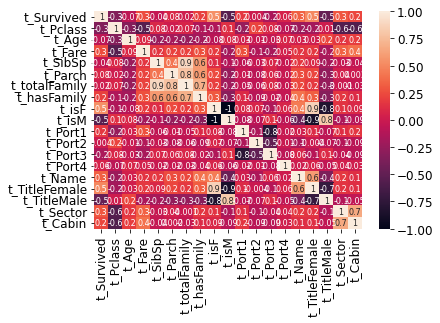

In [29]:
import seaborn as sns
corr_matrix = df_prepared.corr()
print(type(corr_matrix))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.1g', annot_kws={"fontsize":8}, vmin=-1, vmax=1, xticklabels=list(df_prepared.columns), yticklabels=list(df_prepared.columns))
heatmap.get_figure()
save_fig("correlation_pearson", tight_layout=False)

#### Disco

In [30]:
import dcor
def disCorrelation(df):
  '''
  Calculates Disco correlation matrix, starting from a df with only numerical attributes
  Returns a dataframe with the correlation coefficients
  '''
  discorr = np.ones((len(df.columns),len(df.columns)))
  print(discorr.shape)
  for iX,(labelX,X) in enumerate(df.items()):
    for iY,(labelY,Y) in enumerate(df.items()):
      discorr[iX,iY] = dcor.distance_correlation(X.to_numpy(),Y.to_numpy())
      
  df_discorr = pd.DataFrame(data=discorr,    # values
                            index=df.columns,
                            columns=df.columns,
                           ) 
  return df_discorr
  #return discorr

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [31]:
# discorr_matrix = disCorrelation(df_prepared)
# heatmap = sns.heatmap(discorr_matrix, annot=True, fmt='.1g', annot_kws={"fontsize":8}, vmin=-1, vmax=1, xticklabels=list(df_prepared.columns), yticklabels=list(df_prepared.columns))
# heatmap.get_figure()#.savefig("./images/end_to_end_project/correlation_disco.png")
# save_fig("correlation_disco", tight_layout=False)

In [32]:
#discorr_matrix["t_Survived"].sort_values(ascending=False)

In [33]:
all_features_descending_corr = [
"t_isM",  
#"t_isF",  
"t_TitleMale",
"t_TitleFemale",
"t_Pclass",
"t_Name",  
"t_Sector",
"t_Fare",  
"t_Cabin", 
"t_hasFamily",
"t_totalFamily",
"t_Port1", 
"t_Port3", 
"t_Parch", 
"t_SibSp", 
"t_Age", 
"t_Port4", 
"t_Port2", 
]

from collections import OrderedDict
all_features_plotting_dict = OrderedDict()

all_features_plotting_dict['t_isM'] = 'cat'
all_features_plotting_dict['t_hasFamily'] = 'cat'
all_features_plotting_dict['t_Port1'] = 'cat'
all_features_plotting_dict['t_Port2'] = 'cat'
all_features_plotting_dict['t_Port3'] = 'cat'
all_features_plotting_dict['t_Port4'] = 'cat'

all_features_plotting_dict['t_TitleMale'] = 'disc'
all_features_plotting_dict['t_TitleFemale'] = 'disc'
all_features_plotting_dict['t_Pclass'] = 'disc'
all_features_plotting_dict['t_Sector'] = 'disc'
all_features_plotting_dict['t_Parch'] = 'disc'
all_features_plotting_dict['t_SibSp'] = 'disc'
all_features_plotting_dict['t_totalFamily'] = 'disc'


all_features_plotting_dict['t_Name'] = 'cont'
all_features_plotting_dict['t_Fare'] = 'cont'
all_features_plotting_dict['t_Cabin'] = 'cont'
all_features_plotting_dict['t_Age'] = 'cont'



#### Plot features for survived vs dead (v1)
Please discard this method, since one would have to choose the binning by hand for each distribution and that is inconvenient

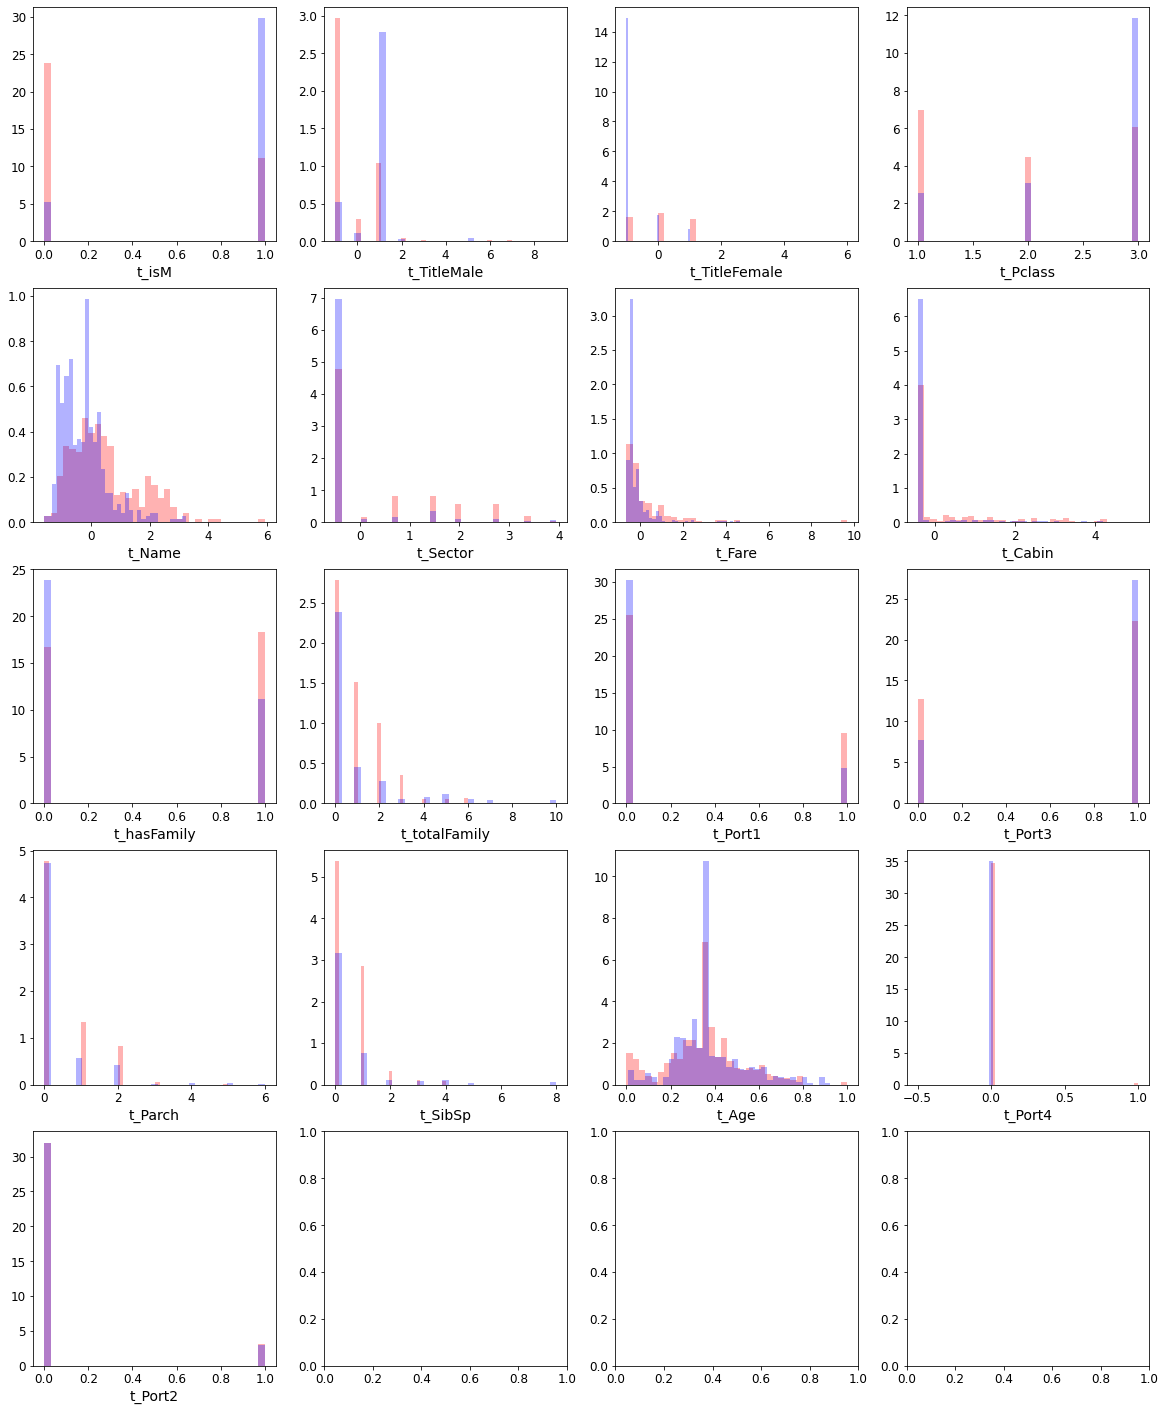

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot all features in a big plot
nrows,ncols=5,4
fig, axes = plt.subplots(nrows, ncols, figsize=(20,25)) # width x height
for i,feat in enumerate(all_features_descending_corr):
  idx_col = i % ncols
  idx_row = (i-idx_col) // ncols

  axes[idx_row][idx_col].hist(df_prepared[(df_prepared["t_Survived"]==1)][feat].array, color='r', alpha=0.3, bins=35, density=True)
  axes[idx_row][idx_col].hist(df_prepared[(df_prepared["t_Survived"]==0)][feat].array, color='b', alpha=0.3, bins=35, density=True)
  #axes[idx_row][idx_col].hist(data[(data.Label=='h')][f_name].array, color='b', alpha=0.5)
  axes[idx_row][idx_col].set_xlabel(feat)

#### Plot features for survived vs dead (v2)

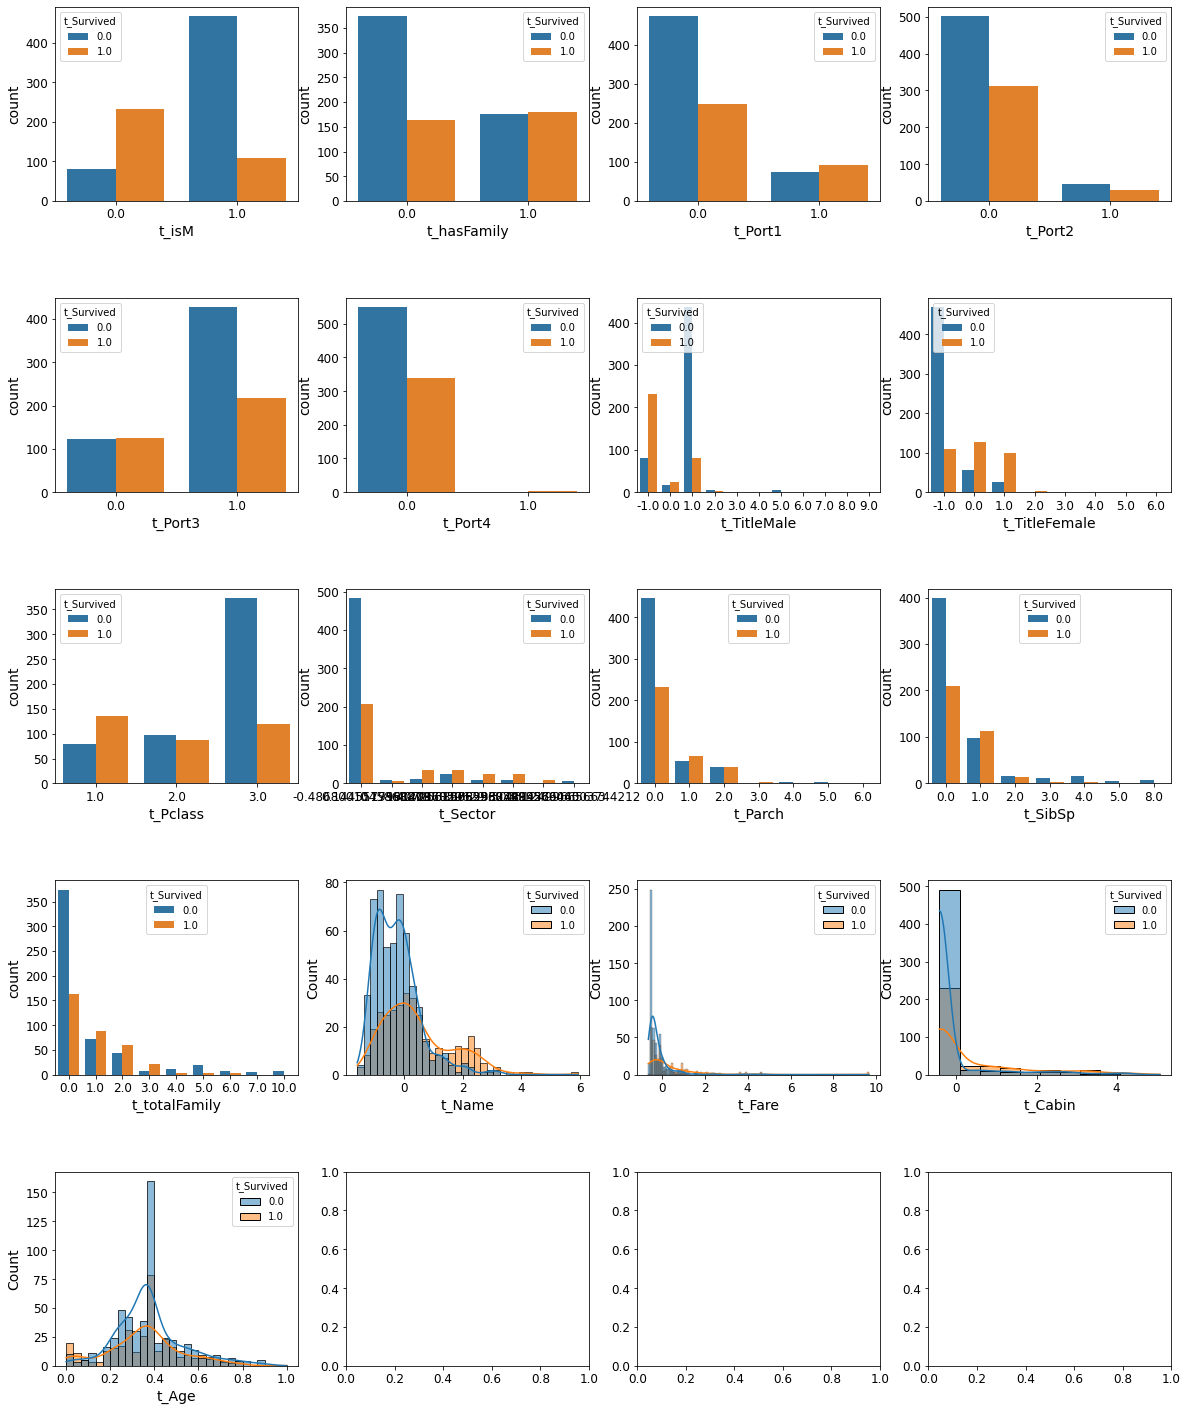

In [35]:
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
ax = ax.flatten() #  ===> apparently needed, if you want to use sns plots with artist layer (ax[i])

i=0
for var,cat in all_features_plotting_dict.items():
  if cat in ['cat', 'disc']:
    sns.countplot(data=df_prepared, x=var, hue="t_Survived", ax=ax[i])
  else:
    sns.histplot(data=df_prepared, x=var, hue="t_Survived", kde=True, ax=ax[i])
    #sns.boxplot(data=df_prepared, x=var, hue="t_Survived", ax=ax[i])
  #ax[i].set_title(f"{var}: Survived vs Not Survived")
  i+=1
    
plt.subplots_adjust(hspace=0.5)
plt.show()

#### What correlation bw Age and Fare?

From the plots below, it seems, that if you survived, there is a correlation bw age and fare, while if you did not survive, there's not much correlation.

This, together with the facts that the fare is a stronger predictor, suggests that the age is not a particularly strong predictor.

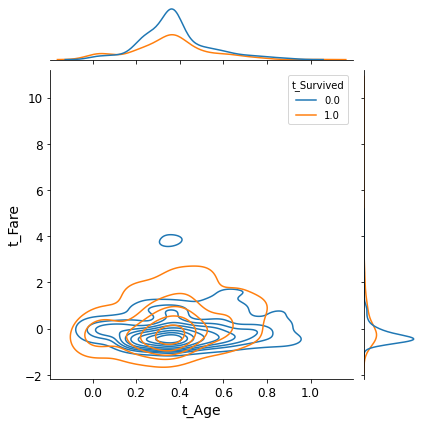

In [36]:
sns.jointplot(x='t_Age',y='t_Fare', data=df_prepared, hue='t_Survived', kind='kde')

However, please note that this joint distribution plot, does not seem to provide the information that the v1 of the visualisation did

i.e. that at low age there is a significant bump in the survival rate. In a decision tree, this information could be used easily...

Therefore, I suggest to keep this information in.

## Training

In [37]:
df_prepared.columns,df_prepared.shape

(Index(['t_Survived', 't_Pclass', 't_Age', 't_Fare', 't_SibSp', 't_Parch',
        't_totalFamily', 't_hasFamily', 't_isF', 't_isM', 't_Port1', 't_Port2',
        't_Port3', 't_Port4', 't_Name', 't_TitleFemale', 't_TitleMale',
        't_Sector', 't_Cabin'],
       dtype='object'),
 (891, 19))

### Models - quick & dirty training

In this phase, I picked up models from different classes:
 - linear
 - decision tree
 - boosted decision tree

I could have additionally picked up e.g. SVM and Neural network, although, it is unlikely that NN will perform better, given low number of examples...

So I believe that the choice of these three is a good starting point.

We use 5-fold cross-validation (remember that we have about 1K examples) and we print for each model
- the accuracy scores 
- the mean of the scores
- the std. dev of the scores

In [38]:
features_descending_corr_for_training = [
"t_isM",  
#"t_isF",  
"t_TitleMale",
"t_TitleFemale",
"t_Pclass",
"t_Name",  
"t_Sector",
"t_Fare",  
"t_Cabin", 
"t_hasFamily",
"t_totalFamily",
"t_Port1", 
"t_Port3", 
"t_Parch", 
"t_SibSp", 
"t_Age", 
"t_Port4", 
"t_Port2", 
#"t_AgeCat",
#"t_FareCat",
]

In [39]:
# prepare the datasets for training from the df_prepared
cv=7 # cross-validation folds

X_train = df_prepared[features_descending_corr_for_training].to_numpy()
Y_train = df_prepared['t_Survived'].to_numpy()

X_train.shape,Y_train.shape

((891, 17), (891,))

In [40]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

sgd_clf = SGDClassifier(random_state=42)

sgd_scores = cross_val_score(sgd_clf,X_train,Y_train,cv=cv,scoring='accuracy')
print(sgd_scores)
print("accuracy: {:.3f} +/- {:.3f}".format(sgd_scores.mean(), sgd_scores.std()))

[0.5390625  0.8203125  0.72440945 0.57480315 0.81102362 0.76377953
 0.81102362]
accuracy: 0.721 +/- 0.108


In [41]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt_clf,X_train,Y_train,cv=cv,scoring='accuracy')

print(dt_scores)
print("accuracy: {:.3f} +/- {:.3f}".format(dt_scores.mean(), dt_scores.std()))

[0.6796875  0.71875    0.80314961 0.77165354 0.80314961 0.80314961
 0.70866142]
accuracy: 0.755 +/- 0.048


In [42]:
import xgboost
xgb_clf = xgboost.XGBClassifier(n_estimators=10, tree_method="hist", nthread=-1)
xgb_scores = cross_val_score(xgb_clf,X_train,Y_train,cv=cv,scoring='accuracy')

print(xgb_scores)
print("accuracy: {:.3f} +/- {:.3f}".format(xgb_scores.mean(), xgb_scores.std()))

[0.8203125  0.84375    0.84251969 0.82677165 0.81889764 0.81102362
 0.81889764]
accuracy: 0.826 +/- 0.012


In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=6,  weights='distance', algorithm='auto', \
                               p=1, metric='minkowski')
knn_scores = cross_val_score(knn_clf,X_train,Y_train,cv=cv,scoring='accuracy')
knn_clf.fit(X_train,Y_train)
print(knn_scores)
print("accuracy: {:.3f} +/- {:.3f}".format(knn_scores.mean(), knn_scores.std()))

[0.7890625  0.828125   0.83464567 0.83464567 0.84251969 0.78740157
 0.8503937 ]
accuracy: 0.824 +/- 0.023


In [44]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, Y_train, cv=cv, scoring='accuracy')

print(svm_scores)
print("accuracy: {:.3f} +/- {:.3f}".format(svm_scores.mean(), svm_scores.std()))

[0.828125   0.8359375  0.86614173 0.80314961 0.83464567 0.78740157
 0.8503937 ]
accuracy: 0.829 +/- 0.025


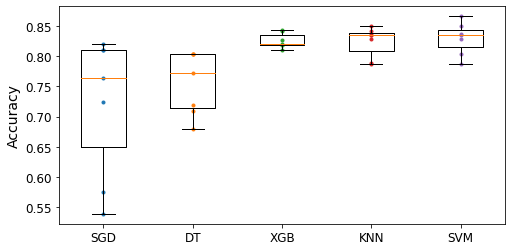

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*cv, sgd_scores, ".")
plt.plot([2]*cv, dt_scores, ".")
plt.plot([3]*cv, xgb_scores, ".")
plt.plot([4]*cv, knn_scores, ".")
plt.plot([5]*cv, svm_scores, ".")
plt.boxplot([sgd_scores, dt_scores, xgb_scores, knn_scores, svm_scores], labels=("SGD", "DT", "XGB", "KNN","SVM"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

- We can observe that there is some overfitting

- xgboost seems the better model, when looking at the plot with cv=7 folds; with cv=10, the difference between xgb and svm is very little

### Which features are essential (order by correlation)? 

Multiple trainings, adding one feature at a time, starting from most correlated with survival probability.

It seems (see below) that maximal performance in all three models is not reached when all features are included.

For the most powerful model, xgboost, we reach maximal performance of 84% accuracy. 
Some observations:
 - not all port information is relevant, some is, but some seems even detrimental
 - there is some redundant information about having spouses of children, (see hasFamily + totalFamily), they don't seem to add much or nothing at all 
 - age does not seem to provide greater discrimination power, but we keep it anyway, since we believe it could be useful in a more complex decision tree or bdt
 
 
*Note:* This feature selection/ranking step is repeated later on, with the ranking by feature importance, which is more solid than correlation with the outcome.  

In [45]:
for ifeat,feat in enumerate(all_features_descending_corr):
  subset_features = all_features_descending_corr[:ifeat+1]
  #print(subset_features)
  X_train = df_prepared[subset_features].to_numpy()
  Y_train = df_prepared['t_Survived'].to_numpy()
  #print(X_train.shape,Y_train.shape)
  #print(X_train[4,:])
  
  sgd_clf = SGDClassifier(random_state=42)
  sgd_scores = cross_val_score(sgd_clf,X_train,Y_train,cv=5,scoring='accuracy')
  sgd_avg,sgd_err=sgd_scores.mean(),sgd_scores.std()
  
  dt_clf = DecisionTreeClassifier(random_state=42)
  dt_scores = cross_val_score(dt_clf,X_train,Y_train,cv=5,scoring='accuracy')
  dt_avg,dt_err=dt_scores.mean(),dt_scores.std()
  
  xgb_clf = xgboost.XGBClassifier(n_estimators=10, tree_method="hist", nthread=-1)
  xgb_scores = cross_val_score(xgb_clf,X_train,Y_train,cv=5,scoring='accuracy')
  xgb_avg,xgb_err=xgb_scores.mean(),xgb_scores.std()

  knn_clf = KNeighborsClassifier(n_neighbors=6,  weights='distance', algorithm='auto', \
                               p=1, metric='minkowski')
  knn_scores = cross_val_score(knn_clf,X_train,Y_train,cv=5,scoring='accuracy')
  knn_avg,knn_err=knn_scores.mean(),knn_scores.std()
  
  print('Added {:10}, lin = {:.2f} +/- {:.2f}, tree = {:.2f} +/- {:.2f}, xgb =  {:.2f} +/- {:.2f}, knn =  {:.2f} +/- {:.2f}'.format(
          feat,sgd_avg,sgd_err,dt_avg,dt_err,xgb_avg,xgb_err,knn_avg,knn_err ))
  
  

Added t_isM     , lin = 0.79 +/- 0.02, tree = 0.79 +/- 0.02, xgb =  0.79 +/- 0.02, knn =  0.71 +/- 0.08
Added t_TitleMale, lin = 0.67 +/- 0.23, tree = 0.79 +/- 0.02, xgb =  0.79 +/- 0.02, knn =  0.75 +/- 0.07
Added t_TitleFemale, lin = 0.79 +/- 0.02, tree = 0.79 +/- 0.02, xgb =  0.79 +/- 0.02, knn =  0.77 +/- 0.04
Added t_Pclass  , lin = 0.74 +/- 0.05, tree = 0.78 +/- 0.02, xgb =  0.78 +/- 0.02, knn =  0.79 +/- 0.03
Added t_Name    , lin = 0.70 +/- 0.17, tree = 0.79 +/- 0.01, xgb =  0.78 +/- 0.01, knn =  0.80 +/- 0.01
Added t_Sector  , lin = 0.78 +/- 0.02, tree = 0.78 +/- 0.02, xgb =  0.79 +/- 0.02, knn =  0.80 +/- 0.02
Added t_Fare    , lin = 0.66 +/- 0.17, tree = 0.77 +/- 0.02, xgb =  0.82 +/- 0.01, knn =  0.79 +/- 0.02
Added t_Cabin   , lin = 0.75 +/- 0.06, tree = 0.77 +/- 0.01, xgb =  0.82 +/- 0.01, knn =  0.80 +/- 0.02
Added t_hasFamily, lin = 0.75 +/- 0.04, tree = 0.77 +/- 0.02, xgb =  0.82 +/- 0.01, knn =  0.80 +/- 0.02
Added t_totalFamily, lin = 0.76 +/- 0.01, tree = 0.78 +/- 0

## Model Optimisation

In [46]:
from sklearn.model_selection import GridSearchCV

X_train = df_prepared[all_features_descending_corr].to_numpy()
Y_train = df_prepared['t_Survived'].to_numpy()

### XGBoost optimisation

#### Hyperparameters tuning

XGBoost has a big number of hyperparameters but not all of them are important.

Among the most important ones are (cf https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9):

- *n_estimators*: specifies the number of decision trees to be boosted. If n_estimator = 1, it means only 1 tree is generated, thus no boosting is at work. The default value is 100, but you can play with this number for optimal performance.
- *subsample*: it represents the subsample ratio of the training sample. A subsample = 0.5 means that 50% of training data is used prior to growing a tree. The value can be any fraction but the default value is 1.
- *max_depth*: it limits how deep each tree can grow. The default value is 6 but you can try other values if overfitting is an issue in your model.
- *learning_rate* (alias: eta): it is a regularization parameter that shrinks feature weights in each boosting step. The default value is 0.3 but people generally tune with values such as 0.01, 0.1, 0.2 etc.
- *gamma* (alias: min_split_loss): it’s another regularization parameter for tree pruning. It specifies the minimum loss reduction required to grow a tree. The default value is set at 0.
- *reg_alpha* (alias: alpha): it is the L1 regularization parameter, increasing its value makes the model more conservative. Default is 0.
- *reg_lambda* (alias: lambda): L2 regularization parameter, increasing its value also makes the model conservative. Default is 1.


I started from 'n_estimators': [30, 300, 500], 'max_depth': [6, 10, 20], 'subsample': [0.1, 1.0], 'learning_rate': [0.005,0.01, 0.3]},
but I observe some over-training (diff bw performance on training set and test set is 


In [115]:
param_grid = [
    {'n_estimators': [30, 300, 500], 
     'max_depth': [3, 6, 20], 
     'subsample': [0.1, 1.0], 
     'learning_rate': [0.005, 0.01, 0.3]},
  ]

#forest_reg = RandomForestRegressor(random_state=42)
xgb_clf = xgboost.XGBClassifier(tree_method="hist")

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method='hist

In [116]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500, 'subsample': 1.0}

In [117]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [118]:
cvres = grid_search.cv_results_
#cvres

In [119]:
#for mean_score, std_test_score, rank_test_score, params in zip(cvres["mean_test_score"], cvres["std_test_score"], cvres["rank_test_score"], cvres["params"]):
#    print(mean_score, std_test_score, rank_test_score, params)
    
pd.set_option('max_colwidth', -1)
df_cvres = pd.DataFrame(grid_search.cv_results_)
df_cvres[["mean_test_score", "std_test_score", "mean_train_score", "rank_test_score", "params"]].sort_values(by="rank_test_score")

/var/folders/n_/3tsts8n517l9sdcmgskvkyqc0000gn/T/ipykernel_45734/210670157.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,mean_test_score,std_test_score,mean_train_score,rank_test_score,params
35,0.832779,0.010780,0.965207,1,"{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500, 'subsample': 1.0}"
11,0.832773,0.017180,0.913860,2,"{'learning_rate': 0.005, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1.0}"
27,0.832766,0.014007,0.916385,3,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}"
33,0.832754,0.015419,0.942199,4,"{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 300, 'subsample': 1.0}"
34,0.831662,0.009831,0.856905,5,"{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.1}"
17,0.831636,0.022840,0.931817,6,"{'learning_rate': 0.005, 'max_depth': 20, 'n_estimators': 500, 'subsample': 1.0}"
28,0.830538,0.010713,0.858027,7,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.1}"
9,0.830532,0.019870,0.904603,8,"{'learning_rate': 0.005, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}"
15,0.827155,0.023979,0.921998,9,"{'learning_rate': 0.005, 'max_depth': 20, 'n_estimators': 300, 'subsample': 1.0}"
3,0.826031,0.019840,0.846520,10,"{'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}"


There is significant overtraining, I will try to regularise the model, starting from the parameter choice that gives a good performance on the test set and a similar one on the validation set. 


rank 17: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.1}

rank 5 : {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.1}

In [120]:
param_grid_regular = [
   {'learning_rate': [0.01], 'max_depth': [6], 'n_estimators': [300], 'subsample': [0.1], 
     'gamma': [0,0.01,0.1,1.], 'reg_alpha':[0,0.01,0.1,1.], 'reg_lambda':[0,0.01,0.1,1],}
  ]

xgb_clf_regular = xgboost.XGBClassifier(tree_method="hist")

grid_search_regular = GridSearchCV(xgb_clf_regular, param_grid_regular, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search_regular.fit(X_train, Y_train)



GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method='hist',


In [121]:
cvres_regular = grid_search_regular.cv_results_
df_cvres_regular = pd.DataFrame(grid_search_regular.cv_results_)
pd.set_option('max_rows', 500)
df_cvres_regular[["mean_test_score", "std_test_score", "mean_train_score", "rank_test_score", "params"]].sort_values(by="rank_test_score")


,mean_test_score,std_test_score,mean_train_score,rank_test_score,params
1,0.831649,0.010666,0.861113,1,"{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.1}"
4,0.831643,0.010761,0.859430,2,"{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.1}"
37,0.830525,0.013504,0.860833,3,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.1}"
36,0.830519,0.011012,0.860272,4,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.1}"
33,0.830519,0.011012,0.859710,4,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.1}"
17,0.830519,0.012104,0.859430,6,"{'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.1}"
24,0.830519,0.011012,0.858027,6,"{'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.1}"
8,0.830519,0.011012,0.858588,6,"{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.1}"
54,0.830513,0.012689,0.856063,9,"{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'subsample': 0.1}"
34,0.829396,0.010563,0.858869,10,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.1}"


The tuning of the regularisation parameters does not change the picture dramatically.

The presence of a little overtraining can be tolerated.

#### Second Hyperparameter tuning

I want to understand the effect of a couple of parameters at a time. The most important ones to me seem the n_estimators and max_depth


In [50]:
param_grid0 = [
    {'n_estimators': [3, 6, 10, 20, 30, 40, 100, 300, 500], 
     'max_depth':    [2, 3, 6, 10, 20], 
     'learning_rate':[0.3],
     'subsample':    [1.0], # subsample ratio of the training sample
     'gamma':        [0.], # minimum loss reduction required to grow a tree , not independent on n_estimators
     'reg_alpha':    [0.],
     'reg_lambda':   [1.],
    },
  ]


#forest_reg = RandomForestRegressor(random_state=42)
xgb_clf = xgboost.XGBClassifier(tree_method="hist")

grid_search = GridSearchCV(xgb_clf, param_grid0, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method='hist',


In [81]:
cvres = grid_search.cv_results_
df_cvres = pd.DataFrame(grid_search.cv_results_)
df_cvres.columns
df_cvres = df_cvres[["mean_train_score", "mean_test_score", "param_n_estimators", 'param_max_depth']]
df_cvres.insert(2,column='diff_train_test_perc', value=(df_cvres['mean_train_score']/df_cvres['mean_test_score'] - 1)*100 )
df_cvres.sort_values('diff_train_test_perc').head(10)


,mean_train_score,mean_test_score,diff_train_test_perc,param_n_estimators,param_max_depth
0,0.833893,0.833871,0.002634,3,2
1,0.835296,0.821568,1.670943,6,2
2,0.839225,0.824920,1.734062,10,2
10,0.851291,0.820413,3.763714,6,3
9,0.847923,0.817061,3.777187,3,3
3,0.856064,0.815944,4.917077,20,2
4,0.867286,0.815950,6.291523,30,2
11,0.863356,0.809234,6.688048,10,3
5,0.877946,0.817067,7.450883,40,2
18,0.893659,0.828297,7.891138,3,6


We have ranked our hyperparameters by the least percentage difference bw train_score and test_score.

The higher the values of `n_estimators` and `max_depth`, the higher the overtraining.

We note that the most robust model is the first one, with very little difference bw train and test score. It is also providing the almost top test_score performance.

Next, we check the `subsample` parameter, which we actually don't expect to improve the performance, and `learning_rate`, for which some improvement could be obtained by reduction. 

In [84]:
param_grid1 = [
    {'n_estimators': [3], 
     'max_depth':    [2], 
     'learning_rate':[0.05, 0.1, 0.2, 0.3],
     'subsample':    [0.1, 0.5, 1.0], # subsample ratio of the training sample
     'gamma':        [0.], # minimum loss reduction required to grow a tree , not independent on n_estimators
     'reg_alpha':    [0.],
     'reg_lambda':   [1.],
    },
  ]

xgb_clf = xgboost.XGBClassifier(tree_method="hist")

grid_search = GridSearchCV(xgb_clf, param_grid1, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method='hist',


In [86]:
cvres = grid_search.cv_results_
df_cvres = pd.DataFrame(grid_search.cv_results_)
df_cvres.columns
df_cvres = df_cvres[["mean_train_score", "mean_test_score", "param_subsample", 'param_learning_rate']]
df_cvres.insert(2,column='diff_train_test_perc', value=(df_cvres['mean_train_score']/df_cvres['mean_test_score'] - 1)*100 )
df_cvres.sort_values('diff_train_test_perc').head(10)


,mean_train_score,mean_test_score,diff_train_test_perc,param_subsample,param_learning_rate
3,0.799378,0.812592,-1.626140,0.1,0.1
6,0.799099,0.808129,-1.117421,0.1,0.2
0,0.801341,0.809221,-0.973721,0.1,0.05
9,0.801062,0.808129,-0.874448,0.1,0.3
8,0.833893,0.833871,0.002634,1,0.2
11,0.833893,0.833871,0.002634,1,0.3
10,0.827722,0.826006,0.207797,0.5,0.3
2,0.815093,0.804758,1.284271,1,0.05
5,0.829680,0.815994,1.677166,1,0.1
1,0.809203,0.795769,1.688107,0.5,0.05


We don't observe any performance improvement with `subsample` (as expected); we also don't observe it with `learning_rate`.

#### Feature importance

We will rank the feature importance now and see if we can improve performance by dropping some more..

**TODO: check other feature importance ranking methods?**

In [ ]:
xgb_clf_optimal = grid_search_regular.best_estimator_

In [ ]:
imps_xgb = xgb_clf_optimal.feature_importances_

In [ ]:
def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(np.int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
    plt.show()

In [ ]:
plot_feature_importances(imps_xgb, all_features_descending_corr, "Gradient Boosting")

It seems that the feature "t_TitleMale", which also encapsulates information about the gender, is by far the most important feature for the prediction, followed by ticket class, members of family, sector of cabin.

Some observations:
- t_isMale is not very relavant because this info is already present in t_TitleMale
- t_TitleFemale is also not very relevant apparently
- t_hasFamily, t_sibSp, t_Parch, being highly correlated with t_totalFamily, also have a lesser impact than expected by looking at their correlation with the survival rate 
- t_Cabin and t_Sector had a significant correlation; unexpectedly, the cabin number seems more important than the sector: sign of overtraining?
- t_Fare and t_Pclass also had a significant correlation; it seems that Pclass has a more pronounced impact than t_Fare: we can hypothesize that t_Fare is a worse feature, given its skewness

We repeat the training, by adding one feature at a time in this order and see if we can drop something


In [ ]:
data_tuples = list(zip(all_features_descending_corr,imps_xgb))
df_imps_xgb = pd.DataFrame( data=data_tuples, columns=['FeatureName','Importance'])
all_features_descending_imp = df_imps_xgb.sort_values(by='Importance', ascending=False)['FeatureName'].to_list()

In [ ]:
for ifeat,feat in enumerate(all_features_descending_imp):
  subset_features = all_features_descending_imp[:ifeat+1]
  #print(subset_features)
  X_train = df_prepared[subset_features].to_numpy()
  Y_train = df_prepared['t_Survived'].to_numpy()
  
  #print(X_train.shape,Y_train.shape)
  
  #xgb_clf = sklearn.base.clone(xgb_clf_optimal)
  xgb_clf = xgboost.XGBClassifier(tree_method="hist", gamma=1.0, learning_rate=0.005, max_depth=20, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0)
  xgb_scores = cross_val_score(xgb_clf,X_train,Y_train,cv=5,scoring='accuracy')
  xgb_avg,xgb_err=xgb_scores.mean(),xgb_scores.std()

  print('Added {:10}, xgb =  {:.3f} +/- {:.3f}'.format(
          feat,xgb_avg,xgb_err))

It can be seen that, until t_Cabin, the improvement it's pretty neat; for the remaining features there isn't a truly monotonic improvement of the accuracy.
However, keeping all features does not seem to overall affect the performance negatively. Hence all features will be kept.

#### (OBSOLETE) Other metrics and Decision boundary optimisation
Precision and recall curves, for different probability thresholds, can be obtained with sklearn functions.
But there are no methods for getting e.g. accuracy curve; so we compute it for every threshold and optimise the decision boundary to maximise the accuracy.
We don't expect the optimisation to be very significant, given that the loss function for the training was the accuracy... It's more of an exercise, to apply the concepts learnt in chapter 3 of the Hands-on ML book.

In [ ]:
# pure prediction: note that cross_val_predict produces a prediction on each data point, using the model on the other folds
Y_cv_pred = cross_val_predict(xgb_clf_optimal, X_train, Y_train, cv=5)
# predicted probability (score) on the training set
Y_cv_scores = cross_val_predict(xgb_clf_optimal, X_train, Y_train, cv=5, method='predict_proba')
Y_cv_scores = Y_cv_scores[:,1]

In [ ]:
Y_cv_pred.shape,Y_cv_scores.shape,Y_train.shape

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix

In [ ]:
roc_auc_train = roc_auc_score(Y_train, Y_cv_scores)
roc_auc_train

In [ ]:
confusion_matrix(Y_train, Y_cv_pred)

In [ ]:
confusion_matrix(Y_train, Y_cv_pred).ravel()

This means that there are:
- TN: 494, they died and predicted to die
- FP: 55, they died but predicted to survive
- FN: 87, they survived but predicted to die 
- TP: 255, they survived and predicted to survive

In [ ]:
thresholds = np.arange(start=0, stop=1, step=0.01)

def conf_matrix_curve(Y_true, Y_prob, thresholds):
  tn_curve = np.ones(thresholds.shape) * -99
  fp_curve = np.ones(thresholds.shape) * -99
  fn_curve = np.ones(thresholds.shape) * -99
  tp_curve = np.ones(thresholds.shape) * -99
  
  for i,th in enumerate(thresholds):
    Y_pred_thr = (Y_prob>th)
    tn_curve[i], fp_curve[i], fn_curve[i], tp_curve[i] = confusion_matrix(Y_train,Y_pred_thr).ravel()

  return tn_curve,fp_curve,fn_curve,tp_curve

    
tn,fp,fn,tp = conf_matrix_curve(Y_train, Y_cv_scores, thresholds)

precision =  tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (tp+tn) / (tn+fp+fn+tp)
error_rate = 1 - accuracy


In [ ]:
thresholds.shape,tn.shape

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, tn, '-b', label='TN')
plt.plot(thresholds, fn, '--b',label='FN')
plt.plot(thresholds, tp, '-r',label='TP')
plt.plot(thresholds, fp, '--r',label='FP')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(thresholds, precision, '-b',label='precision (accuracy of the positives)')
plt.plot(thresholds, recall,    '-r',label='recall (efficiency of the positives)')
plt.plot(thresholds, accuracy,  '--g', label='accuracy')
plt.xlabel('threshold',fontsize=16)
plt.ylabel('metric',fontsize=16)
plt.legend()

idx_max = accuracy.argmax()
thr_max = thresholds[idx_max]
acc_max = accuracy[idx_max]
print('max accuracy thr={:2f}, acc={:2f}'.format(thr_max,acc_max))
print('default      thr={:2f}, acc={:2f}'.format(thresholds[50],accuracy[50]))

The result of the optimisation is that the decision boundary should be put at 0.53 instead of 0.5, but the improvement is really minor as expected

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_train, Y_cv_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(6, 4))                                    
plot_roc_curve(fpr, tpr)
plt.show()

#### Error analysis

can we figure out why some predictions are bad?

## Submission

### Preprocessing
Get the test set and pre-process it

In [87]:
df_start_test = pd.read_csv('test.csv')
df_start_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [88]:
# I had to make sure that df_start did not have the survived column, so that format is uniform bw train and test when going through the transform pipeline
features_np_prepared_test = full_pipeline.transform(df_start_test)
print(features_np_prepared.shape,features_np_prepared_test.shape)
print(df_start.shape,df_start_test.shape)

(891, 18) (418, 18)
(891, 12) (418, 11)


In [89]:
df_prepared_test = pd.DataFrame(data=features_np_prepared_test,    # values
                                #index=df_start_test.index,    # indexing column, otherwise it will use numbers from 0 on
                                columns=column_names[1:])         # column names, otherwise it will use numbers from 0 on
#df_prepared_test.to_csv('test_prepared.csv')
df_prepared_test.head()

,t_Pclass,t_Age,t_Fare,t_SibSp,t_Parch,t_totalFamily,t_hasFamily,t_isF,t_isM,t_Port1,t_Port2,t_Port3,t_Port4,t_Name,t_TitleFemale,t_TitleMale,t_Sector,t_Cabin
0,3.0,0.428248,-0.490783,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.182055,-1.0,1.0,-0.4868,-0.421322
1,3.0,0.585323,-0.507479,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.542753,1.0,-1.0,-0.4868,-0.421322
2,2.0,0.773813,-0.453367,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.211850,-1.0,1.0,-0.4868,-0.421322
3,3.0,0.334004,-0.474005,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.182055,-1.0,1.0,-0.4868,-0.421322
4,3.0,0.271174,-0.401017,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.836359,1.0,-1.0,-0.4868,-0.421322


In [90]:
# further transformation
#df_prepared['t_AgeCat'] = pd.cut(df_prepared['t_Age'],age_binning, labels=False)
#df_prepared['t_FareCat'] = pd.cut(df_prepared['t_Fare'],Fare_binning, labels=False)

In [91]:
X_test = df_prepared_test[features_descending_corr_for_training].to_numpy()
#Y_test = df_prepared['t_Survived'].to_numpy()

X_train.shape,X_test.shape

((891, 17), (418, 17))

### Predict probabilities
Predict the probabilities using the optimal classifiers, set the predictions to y_prob>0.53 , output the predictions along with passenger id

In [93]:
# v01
#Y_test_scores = xgb_clf_optimal.predict_proba(X_test)
#v02
#Y_test_scores = knn_clf.predict_proba(X_test)
# v03
#xgb_clf_myoptim = xgboost.XGBClassifier(tree_method="hist",learning_rate=0.01,max_depth=20,n_estimators=500,subsample=0.1)
#xgb_clf_myoptim.fit(X_train,Y_train)
# v04
#xgb_clf_myoptim = xgboost.XGBClassifier(tree_method="hist", learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.1)
# v05 MORE ROBUST MODEL, reasonable hyperparameter tuning, little overtraining observed
xgb_clf_myoptim = xgboost.XGBClassifier(tree_method="hist", learning_rate=0.3, max_depth=2, n_estimators=3, subsample=1.0)
xgb_clf_myoptim.fit(X_train,Y_train)
Y_test_scores = xgb_clf_myoptim.predict_proba(X_test)

Y_test_scores = Y_test_scores[:,1]

Y_test_scores.shape

Y_test_pred = (Y_test_scores>0.50).astype(int)
df_start_test['Survived']=Y_test_pred
df_output = df_start_test[['PassengerId','Survived']]

In [94]:
print(df_output.shape)
df_output.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [95]:
df_output.to_csv('submission05_xgb.csv', index=False)

Some Learnings:


Using the column pipeline for transforming the feature is neat, but has limitations, e.g. you cannot use features that you created with a transformer of another column

The choice of the hyperparameters of xgboost so that the scores bw test set and training set was not too high seems to have gained me a ~1% accuracy in the test set (and a significant boost in the leaderboard... honestly it seems a bit by chance... when I tried to perform an even more robust hyperparameter tuning, which had given an ~83% performance on both tranining set and validation set, I would have expected an improvement on the test set.

More things that I could do to improve performance:
- average predictions from different models
- better imputation of the age, based on the title